In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic

# for GP regression validation 
import statsmodels.api as sm
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import os

In [2]:
# Code for regression part is modified from code from "universal functional regression with neural operator flows"

train_samples = 10000 # in regression

# notice the n_x doesn't need to be the same as the n_x used in traininig
# OFM is functional prior, e.g, In trianing prior, we use n_x = 128. For regression, we can set n_x = 256, 512, or higher.
n_x = 128

dims = [n_x]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
spath = Path('your_path/GP')
spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
#random_seeds = [2**i for i in range(10)]
#np.random.seed(22)
torch.manual_seed(22) # fix the seed for reproducible regression result
modes = 32
width = 256
mlp_width = 128

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default


## Dataset parameters
length_scale_x = 0.3
var_x = 1
nu_x = 1.5

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 1024

torch.Size([10000, 1, 128])


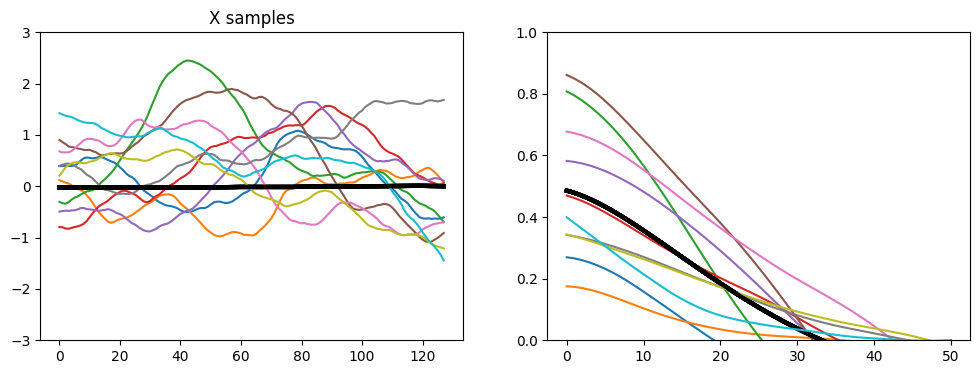

In [3]:
## Prepare training dataset
torch.manual_seed(22) # fix the seed for reproducible result

GP_1C = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device='cpu', dims=dims)
x_test = GP_1C.sample_from_prior(dims=dims, n_samples=train_samples)

loader_tr = DataLoader(x_test, batch_size=batch_size, shuffle=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_test.mean(dim=0).squeeze()
x_hist_true, bin_edges = x_test.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_test[i,0,:].numpy(), nlag=50)) for i in range(train_samples)]).mean(dim=0)
#train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test), batch_size=batch_size, shuffle=True)

print(x_test.shape)
for i in range(10):
    x = x_test[i,0]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
plt.show()


## load trained model

In [4]:
## load trained model

model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=1, t_scaling=1).to(device)
    
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu',weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [5]:
x_hist_true, bin_edges = x_test.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

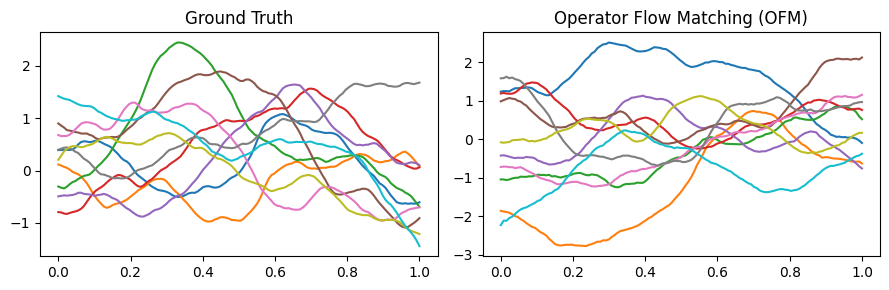

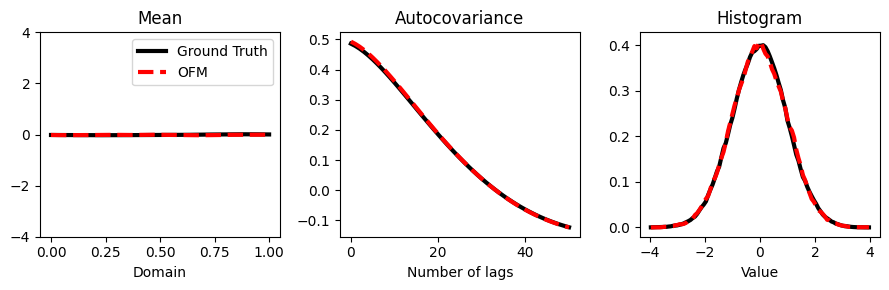

In [6]:
with torch.no_grad():
    X_hat = fmot.sample([n_x], n_samples=10, n_eval=10).cpu().squeeze()
    X_ground_truth = x_test[:10].squeeze()
    # plot
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x], n_samples=1000, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)    
    for i in range(10):
        x = X_hat[i,:]
        x_ground_truth = X_ground_truth[i,:]
        ax[0].plot(x_pos, x_ground_truth)
        ax[0].set_title('Ground Truth')
        ax[1].plot(x_pos, x)
        ax[1].set_title('Operator Flow Matching (OFM)')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}_samples.pdf")
    
    x_mean = X_alt.mean(dim=0)
    x_acovf = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i, :], nlag=50)) for i in range(3000)]).mean(dim=0)
    
    fig, ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].plot(x_pos, x_mean_true, c='k', lw=3, label='Ground Truth')
    ax[0].plot(x_pos, x_mean, c='r', ls='--', lw=3, label='OFM')
    ax[0].set_xlabel('Domain')
    ax[0].set_ylim([-4,4])
    ax[0].set_title('Mean')
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(x_acovf, c='r',ls='--', lw=3)
    #ax[1].set_ylim([0,0.5])
    ax[1].set_xlabel('Number of lags')
    ax[1].set_title('Autocovariance')
    ax[2].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Ground Truth')
    ax[2].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3, label='OpFlow')
    ax[2].set_title('Histogram')
    ax[2].set_xlabel('Value')
    ax[0].legend(loc='upper right')
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}_statistic.pdf")

## Regression 

$$\log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \Big| \lbrace \widehat u(x_i) \rbrace_{i=1}^n \right) =  -\frac{\sum_{i=1}^n \lVert \widehat u(x_i) - u(x_i) \rVert^2}{2\sigma^2} + \log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \right) + C  
$$

In [22]:
# lr : learning rate used in MAP estimation
# noise_level: a predefined noise-level, \sigma^2

ndim = n_x #128
lr = 1e-3 
epochs = 4000 # epoch for MAP 
noise_level = 0.01

# extract 6 random observations from a test sample
pos_mask = torch.zeros(ndim)
pos_idx = np.random.choice(ndim, 6, replace=False)

pos_mask[pos_idx] = 1
pos_mask = (pos_mask==1)

# The ground truth that we used to extract random observation
u_obs_full = x_test[100:101,0:1]
u_obs_part = u_obs_full[:,:,pos_mask].to(device)

# generated noisy observation by injecting white noise
noise_pattern =  torch.randn_like(u_obs_part)
u_obs_part = u_obs_part + noise_pattern* np.sqrt(noise_level)

# saved for further use
u_obs_full = u_obs_full.squeeze()
u_obs_part_detach = u_obs_part.detach().cpu()

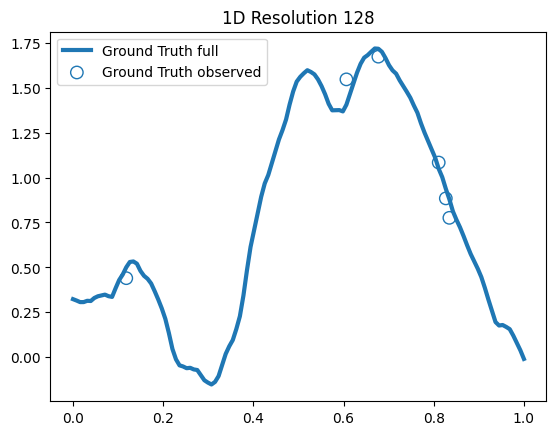

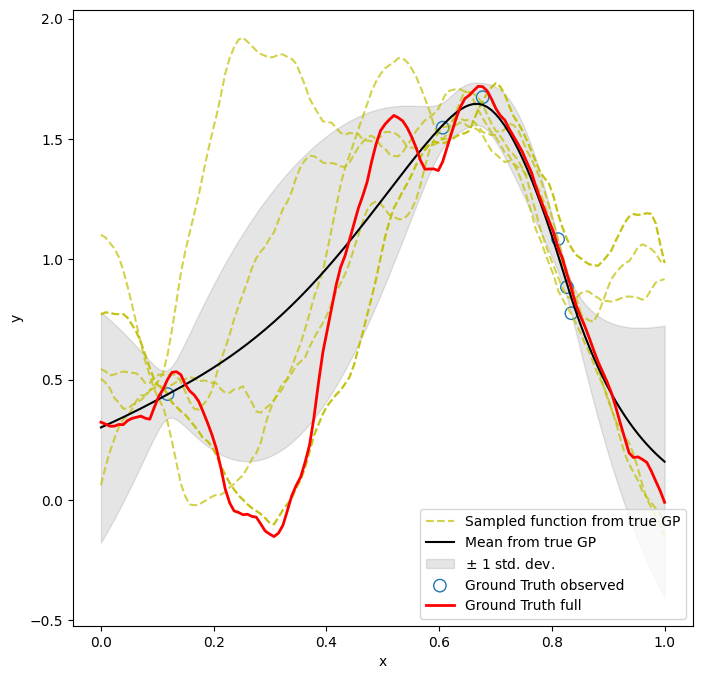

In [26]:
x_range = np.linspace(0,1,ndim)
X = x_range.reshape(-1, 1)

plt.plot(x_range, u_obs_full, label='Ground Truth full', lw=3, c='#1f77b4')
plt.scatter(x_range[pos_mask], u_obs_part_detach , s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.title('1D Resolution 128', fontsize=12)
plt.legend()

## Ground Truth GP
#true_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)  + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
true_kernel = 1.0 * Matern(length_scale=length_scale_x, nu=nu_x) 

gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=noise_level)

x_obs = x_range[pos_mask][:,np.newaxis]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 

y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, 5)

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8, 8))
for idx, single_prior in enumerate(y_samples.T):
    ax.plot(
        x_range,
        single_prior,
        linestyle="--",
        alpha=0.7,
        c = 'y'
    )
    if idx==4:
        ax.plot(
            x_range,
            single_prior,
            linestyle="--",
            alpha=0.7,
            c = 'y',
            label=f"Sampled function from true GP",
        )        
    

ax.plot(x_range, y_mean, color="black", label="Mean from true GP")
ax.fill_between(
    x_range,
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(x_range[pos_mask], u_obs_part_detach , s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full, label='Ground Truth full', lw=2, c='r')
ax.legend()

## Get the Maximum a posteriori (MAP) estimation (optional)

In [17]:
G = fmot

In [18]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,1, ndim))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inv_sample(self.a_target, n_eval=4, forward=True)
        
    def logp(self):
        u, out_logp, prior_logp = self.G.data_likelihood_precise(self.a_target, n_eval=4, forward=True)

        return u, out_logp

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        cur_u, cur_logp = reg_opflow_a.logp()
        
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:, :, pos_mask])**2)/noise_level
        #loss2 = reg_opflow_a.logp()
        loss1 = -0.5*torch.sum((u_obs_part[0] - cur_u[:,  pos_mask])**2)/noise_level
        loss2 = cur_logp
        
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses

In [19]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [21]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

epcoh:0, loss:1001.0636596679688
epcoh:1, loss:992.8878173828125
epcoh:2, loss:991.7139892578125
epcoh:3, loss:993.4781494140625
epcoh:4, loss:992.14208984375
epcoh:5, loss:987.3659057617188
epcoh:6, loss:976.632568359375
epcoh:7, loss:978.516357421875
epcoh:8, loss:974.7750854492188
epcoh:9, loss:975.8353271484375
epcoh:10, loss:971.497802734375
epcoh:11, loss:964.2713012695312
epcoh:12, loss:961.1190185546875
epcoh:13, loss:960.1043090820312
epcoh:14, loss:954.8868408203125
epcoh:15, loss:952.12353515625
epcoh:16, loss:956.4013671875
epcoh:17, loss:950.4013671875
epcoh:18, loss:946.640869140625
epcoh:19, loss:936.6026611328125
epcoh:20, loss:933.5860595703125
epcoh:21, loss:931.5930786132812
epcoh:22, loss:931.245361328125
epcoh:23, loss:928.7974243164062
epcoh:24, loss:920.8451538085938
epcoh:25, loss:921.6202392578125
epcoh:26, loss:926.80908203125
epcoh:27, loss:913.0552368164062
epcoh:28, loss:910.1895751953125
epcoh:29, loss:916.9166259765625
epcoh:30, loss:910.3792724609375
epc

epcoh:249, loss:637.3662719726562
epcoh:250, loss:631.0227661132812
epcoh:251, loss:636.4404907226562
epcoh:252, loss:640.9686279296875
epcoh:253, loss:638.6405639648438
epcoh:254, loss:631.1513061523438
epcoh:255, loss:637.4942016601562
epcoh:256, loss:635.863525390625
epcoh:257, loss:644.2656860351562
epcoh:258, loss:634.3649291992188
epcoh:259, loss:631.25244140625
epcoh:260, loss:638.193359375
epcoh:261, loss:639.719970703125
epcoh:262, loss:637.5908203125
epcoh:263, loss:632.1808471679688
epcoh:264, loss:633.493408203125
epcoh:265, loss:641.5507202148438
epcoh:266, loss:633.18505859375
epcoh:267, loss:638.9483642578125
epcoh:268, loss:637.216796875
epcoh:269, loss:643.720703125
epcoh:270, loss:632.86328125
epcoh:271, loss:631.3322143554688
epcoh:272, loss:637.1028442382812
epcoh:273, loss:634.2982177734375
epcoh:274, loss:627.7454833984375
epcoh:275, loss:629.5979614257812
epcoh:276, loss:626.723876953125
epcoh:277, loss:628.9163208007812
epcoh:278, loss:631.5013427734375
epcoh:27

epcoh:494, loss:604.8958129882812
epcoh:495, loss:599.3448486328125
epcoh:496, loss:602.817138671875
epcoh:497, loss:612.5836791992188
epcoh:498, loss:593.4434814453125
epcoh:499, loss:608.760986328125
epcoh:500, loss:607.0848999023438
epcoh:501, loss:599.6441040039062
epcoh:502, loss:606.323486328125
epcoh:503, loss:603.4387817382812
epcoh:504, loss:608.5323486328125
epcoh:505, loss:604.131591796875
epcoh:506, loss:605.0145263671875
epcoh:507, loss:614.5177612304688
epcoh:508, loss:604.5595703125
epcoh:509, loss:608.30322265625
epcoh:510, loss:607.44580078125
epcoh:511, loss:609.8054809570312
epcoh:512, loss:606.2850952148438
epcoh:513, loss:607.876220703125
epcoh:514, loss:611.47021484375
epcoh:515, loss:611.7662963867188
epcoh:516, loss:608.0084228515625
epcoh:517, loss:604.0045166015625
epcoh:518, loss:617.7175903320312
epcoh:519, loss:601.60400390625
epcoh:520, loss:611.861572265625
epcoh:521, loss:605.8148193359375
epcoh:522, loss:603.6895751953125
epcoh:523, loss:604.19763183593

epcoh:739, loss:600.1827392578125
epcoh:740, loss:602.3193969726562
epcoh:741, loss:606.8736572265625
epcoh:742, loss:600.9117431640625
epcoh:743, loss:603.3216552734375
epcoh:744, loss:603.8480224609375
epcoh:745, loss:602.76904296875
epcoh:746, loss:608.7492065429688
epcoh:747, loss:603.3873901367188
epcoh:748, loss:602.0233154296875
epcoh:749, loss:600.4182739257812
epcoh:750, loss:611.2288818359375
epcoh:751, loss:591.5513305664062
epcoh:752, loss:609.9608764648438
epcoh:753, loss:598.8572998046875
epcoh:754, loss:603.6092529296875
epcoh:755, loss:604.895263671875
epcoh:756, loss:602.2776489257812
epcoh:757, loss:601.4623413085938
epcoh:758, loss:593.52392578125
epcoh:759, loss:603.8360595703125
epcoh:760, loss:600.9280395507812
epcoh:761, loss:603.467529296875
epcoh:762, loss:600.7734985351562
epcoh:763, loss:611.051513671875
epcoh:764, loss:597.9255981445312
epcoh:765, loss:604.164306640625
epcoh:766, loss:602.6437377929688
epcoh:767, loss:599.76123046875
epcoh:768, loss:605.6632

epcoh:984, loss:602.489501953125
epcoh:985, loss:600.1790161132812
epcoh:986, loss:599.8162231445312
epcoh:987, loss:600.8221435546875
epcoh:988, loss:594.918212890625
epcoh:989, loss:597.9874877929688
epcoh:990, loss:600.3897705078125
epcoh:991, loss:596.049072265625
epcoh:992, loss:599.8679809570312
epcoh:993, loss:599.97509765625
epcoh:994, loss:596.7360229492188
epcoh:995, loss:590.3392944335938
epcoh:996, loss:598.2500610351562
epcoh:997, loss:600.1588745117188
epcoh:998, loss:606.023681640625
epcoh:999, loss:600.5808715820312
epcoh:1000, loss:598.5850830078125
epcoh:1001, loss:601.9769897460938
epcoh:1002, loss:598.056884765625
epcoh:1003, loss:611.8280029296875
epcoh:1004, loss:594.0391845703125
epcoh:1005, loss:610.3102416992188
epcoh:1006, loss:604.951904296875
epcoh:1007, loss:599.2600708007812
epcoh:1008, loss:601.2615966796875
epcoh:1009, loss:600.7835083007812
epcoh:1010, loss:606.2478637695312
epcoh:1011, loss:604.440185546875
epcoh:1012, loss:602.6907348632812
epcoh:1013

epcoh:1222, loss:605.1390380859375
epcoh:1223, loss:597.727294921875
epcoh:1224, loss:597.5374145507812
epcoh:1225, loss:603.7613525390625
epcoh:1226, loss:599.030029296875
epcoh:1227, loss:605.9146118164062
epcoh:1228, loss:596.1911010742188
epcoh:1229, loss:594.927490234375
epcoh:1230, loss:596.6691284179688
epcoh:1231, loss:601.5657348632812
epcoh:1232, loss:596.1328125
epcoh:1233, loss:596.861083984375
epcoh:1234, loss:604.171142578125
epcoh:1235, loss:598.8580932617188
epcoh:1236, loss:606.142822265625
epcoh:1237, loss:598.5640258789062
epcoh:1238, loss:591.9265747070312
epcoh:1239, loss:597.248291015625
epcoh:1240, loss:601.2250366210938
epcoh:1241, loss:601.5991821289062
epcoh:1242, loss:603.0011596679688
epcoh:1243, loss:604.1587524414062
epcoh:1244, loss:599.4448852539062
epcoh:1245, loss:597.3015747070312
epcoh:1246, loss:600.2958984375
epcoh:1247, loss:603.0477905273438
epcoh:1248, loss:605.0028076171875
epcoh:1249, loss:602.0038452148438
epcoh:1250, loss:591.6983032226562
e

epcoh:1460, loss:600.5297241210938
epcoh:1461, loss:604.6232299804688
epcoh:1462, loss:601.70361328125
epcoh:1463, loss:603.1580200195312
epcoh:1464, loss:598.0482177734375
epcoh:1465, loss:602.1694946289062
epcoh:1466, loss:601.7909545898438
epcoh:1467, loss:601.8419799804688
epcoh:1468, loss:596.8883056640625
epcoh:1469, loss:599.4893798828125
epcoh:1470, loss:603.2687377929688
epcoh:1471, loss:593.3053588867188
epcoh:1472, loss:603.9273681640625
epcoh:1473, loss:602.46875
epcoh:1474, loss:601.684814453125
epcoh:1475, loss:600.6552124023438
epcoh:1476, loss:598.9281616210938
epcoh:1477, loss:597.997802734375
epcoh:1478, loss:604.0479736328125
epcoh:1479, loss:594.6924438476562
epcoh:1480, loss:600.4475708007812
epcoh:1481, loss:599.8346557617188
epcoh:1482, loss:597.0269165039062
epcoh:1483, loss:608.9749755859375
epcoh:1484, loss:602.857177734375
epcoh:1485, loss:599.7777099609375
epcoh:1486, loss:600.760498046875
epcoh:1487, loss:601.6388549804688
epcoh:1488, loss:599.041259765625


epcoh:1698, loss:594.9482421875
epcoh:1699, loss:603.1246337890625
epcoh:1700, loss:600.9403076171875
epcoh:1701, loss:595.2510986328125
epcoh:1702, loss:604.7577514648438
epcoh:1703, loss:603.5460815429688
epcoh:1704, loss:597.3395385742188
epcoh:1705, loss:598.1795654296875
epcoh:1706, loss:597.0786743164062
epcoh:1707, loss:600.2059326171875
epcoh:1708, loss:603.363037109375
epcoh:1709, loss:597.2962646484375
epcoh:1710, loss:598.2241821289062
epcoh:1711, loss:595.7351684570312
epcoh:1712, loss:600.6696166992188
epcoh:1713, loss:601.836669921875
epcoh:1714, loss:596.6714477539062
epcoh:1715, loss:597.8402099609375
epcoh:1716, loss:603.5499267578125
epcoh:1717, loss:595.5549926757812
epcoh:1718, loss:604.2312622070312
epcoh:1719, loss:606.5859985351562
epcoh:1720, loss:604.0381469726562
epcoh:1721, loss:598.5530395507812
epcoh:1722, loss:597.5039672851562
epcoh:1723, loss:599.0849609375
epcoh:1724, loss:600.7639770507812
epcoh:1725, loss:598.4327392578125
epcoh:1726, loss:593.4282226

epcoh:1936, loss:600.0269775390625
epcoh:1937, loss:604.0037841796875
epcoh:1938, loss:598.9409790039062
epcoh:1939, loss:597.5106201171875
epcoh:1940, loss:601.4168090820312
epcoh:1941, loss:596.9302978515625
epcoh:1942, loss:599.0725708007812
epcoh:1943, loss:603.7086791992188
epcoh:1944, loss:600.0789794921875
epcoh:1945, loss:604.099609375
epcoh:1946, loss:599.52294921875
epcoh:1947, loss:608.5076293945312
epcoh:1948, loss:600.2745361328125
epcoh:1949, loss:598.3175659179688
epcoh:1950, loss:603.4057006835938
epcoh:1951, loss:605.0093383789062
epcoh:1952, loss:602.9761962890625
epcoh:1953, loss:602.5064086914062
epcoh:1954, loss:594.53173828125
epcoh:1955, loss:595.3428344726562
epcoh:1956, loss:599.4544677734375
epcoh:1957, loss:598.6688232421875
epcoh:1958, loss:602.1182250976562
epcoh:1959, loss:595.9305419921875
epcoh:1960, loss:589.9119873046875
epcoh:1961, loss:598.8615112304688
epcoh:1962, loss:599.13232421875
epcoh:1963, loss:592.4741821289062
epcoh:1964, loss:597.771850585

epcoh:2174, loss:600.4577026367188
epcoh:2175, loss:592.1010131835938
epcoh:2176, loss:602.091064453125
epcoh:2177, loss:597.4960327148438
epcoh:2178, loss:602.554443359375
epcoh:2179, loss:604.3012084960938
epcoh:2180, loss:597.899658203125
epcoh:2181, loss:602.6591796875
epcoh:2182, loss:601.3284301757812
epcoh:2183, loss:605.1713256835938
epcoh:2184, loss:603.5597534179688
epcoh:2185, loss:602.71240234375
epcoh:2186, loss:596.0447387695312
epcoh:2187, loss:587.8142700195312
epcoh:2188, loss:601.8211669921875
epcoh:2189, loss:602.0090942382812
epcoh:2190, loss:602.7197265625
epcoh:2191, loss:600.5763549804688
epcoh:2192, loss:606.4515380859375
epcoh:2193, loss:599.5877075195312
epcoh:2194, loss:597.973388671875
epcoh:2195, loss:594.1597900390625
epcoh:2196, loss:592.4258422851562
epcoh:2197, loss:598.79638671875
epcoh:2198, loss:600.9540405273438
epcoh:2199, loss:594.3333740234375
epcoh:2200, loss:603.1131591796875
epcoh:2201, loss:595.6520385742188
epcoh:2202, loss:596.16064453125
e

epcoh:2412, loss:600.4844360351562
epcoh:2413, loss:599.82275390625
epcoh:2414, loss:595.2149658203125
epcoh:2415, loss:601.3290405273438
epcoh:2416, loss:594.7686157226562
epcoh:2417, loss:599.9437866210938
epcoh:2418, loss:596.3648681640625
epcoh:2419, loss:600.860595703125
epcoh:2420, loss:594.9669189453125
epcoh:2421, loss:601.8240966796875
epcoh:2422, loss:595.72802734375
epcoh:2423, loss:599.2432861328125
epcoh:2424, loss:600.1810913085938
epcoh:2425, loss:601.1561889648438
epcoh:2426, loss:599.9822387695312
epcoh:2427, loss:596.2010498046875
epcoh:2428, loss:599.0751953125
epcoh:2429, loss:595.128662109375
epcoh:2430, loss:597.837646484375
epcoh:2431, loss:599.1649169921875
epcoh:2432, loss:594.1689453125
epcoh:2433, loss:595.1931762695312
epcoh:2434, loss:606.7297973632812
epcoh:2435, loss:603.5172729492188
epcoh:2436, loss:596.1524047851562
epcoh:2437, loss:595.2734985351562
epcoh:2438, loss:584.6820068359375
epcoh:2439, loss:595.3357543945312
epcoh:2440, loss:600.51318359375


epcoh:2650, loss:599.2254028320312
epcoh:2651, loss:592.6053466796875
epcoh:2652, loss:600.23876953125
epcoh:2653, loss:603.2647094726562
epcoh:2654, loss:595.8668212890625
epcoh:2655, loss:600.6362915039062
epcoh:2656, loss:599.795166015625
epcoh:2657, loss:601.6686401367188
epcoh:2658, loss:597.6515502929688
epcoh:2659, loss:593.3709106445312
epcoh:2660, loss:597.614013671875
epcoh:2661, loss:595.9974365234375
epcoh:2662, loss:601.5567626953125
epcoh:2663, loss:602.0
epcoh:2664, loss:600.0648193359375
epcoh:2665, loss:597.2817993164062
epcoh:2666, loss:592.795166015625
epcoh:2667, loss:600.4979858398438
epcoh:2668, loss:600.820068359375
epcoh:2669, loss:595.1730346679688
epcoh:2670, loss:596.2753295898438
epcoh:2671, loss:594.7310180664062
epcoh:2672, loss:604.7206420898438
epcoh:2673, loss:596.100341796875
epcoh:2674, loss:603.1924438476562
epcoh:2675, loss:598.9491577148438
epcoh:2676, loss:598.3463745117188
epcoh:2677, loss:599.0298461914062
epcoh:2678, loss:602.3036499023438
epco

epcoh:2890, loss:595.6580200195312
epcoh:2891, loss:600.8237915039062
epcoh:2892, loss:598.1585083007812
epcoh:2893, loss:599.1910400390625
epcoh:2894, loss:598.314453125
epcoh:2895, loss:598.594970703125
epcoh:2896, loss:589.0011596679688
epcoh:2897, loss:602.679931640625
epcoh:2898, loss:593.0106201171875
epcoh:2899, loss:595.2305297851562
epcoh:2900, loss:601.6047973632812
epcoh:2901, loss:591.1544799804688
epcoh:2902, loss:598.4625854492188
epcoh:2903, loss:591.3603515625
epcoh:2904, loss:602.310546875
epcoh:2905, loss:595.2478637695312
epcoh:2906, loss:599.7322998046875
epcoh:2907, loss:594.6107788085938
epcoh:2908, loss:599.4909057617188
epcoh:2909, loss:600.4725952148438
epcoh:2910, loss:603.4736938476562
epcoh:2911, loss:596.9334106445312
epcoh:2912, loss:589.9030151367188
epcoh:2913, loss:600.6312866210938
epcoh:2914, loss:600.748291015625
epcoh:2915, loss:589.1099243164062
epcoh:2916, loss:596.1047973632812
epcoh:2917, loss:593.5314331054688
epcoh:2918, loss:605.4054565429688

epcoh:3128, loss:589.2537231445312
epcoh:3129, loss:597.3013916015625
epcoh:3130, loss:596.1826171875
epcoh:3131, loss:596.248291015625
epcoh:3132, loss:599.64990234375
epcoh:3133, loss:600.1688842773438
epcoh:3134, loss:595.436767578125
epcoh:3135, loss:594.2342529296875
epcoh:3136, loss:599.0447998046875
epcoh:3137, loss:594.2651977539062
epcoh:3138, loss:601.1890258789062
epcoh:3139, loss:600.68408203125
epcoh:3140, loss:603.2042846679688
epcoh:3141, loss:596.6298828125
epcoh:3142, loss:600.1764526367188
epcoh:3143, loss:592.4047241210938
epcoh:3144, loss:601.9573974609375
epcoh:3145, loss:599.230712890625
epcoh:3146, loss:594.5657348632812
epcoh:3147, loss:599.4202880859375
epcoh:3148, loss:597.3529052734375
epcoh:3149, loss:597.8291625976562
epcoh:3150, loss:589.9547729492188
epcoh:3151, loss:595.5496826171875
epcoh:3152, loss:602.4725341796875
epcoh:3153, loss:597.0546875
epcoh:3154, loss:597.2581176757812
epcoh:3155, loss:596.6959228515625
epcoh:3156, loss:600.4622802734375
epco

epcoh:3366, loss:607.044677734375
epcoh:3367, loss:597.0625610351562
epcoh:3368, loss:594.1123046875
epcoh:3369, loss:600.1569213867188
epcoh:3370, loss:591.9560546875
epcoh:3371, loss:602.8693237304688
epcoh:3372, loss:595.5185546875
epcoh:3373, loss:602.8597412109375
epcoh:3374, loss:598.5426025390625
epcoh:3375, loss:602.1620483398438
epcoh:3376, loss:596.7636108398438
epcoh:3377, loss:596.3258666992188
epcoh:3378, loss:596.8109130859375
epcoh:3379, loss:599.5812377929688
epcoh:3380, loss:594.9615478515625
epcoh:3381, loss:601.7081298828125
epcoh:3382, loss:591.205078125
epcoh:3383, loss:594.1566162109375
epcoh:3384, loss:596.6674194335938
epcoh:3385, loss:596.7438354492188
epcoh:3386, loss:591.9566650390625
epcoh:3387, loss:605.1509399414062
epcoh:3388, loss:598.834716796875
epcoh:3389, loss:594.3114013671875
epcoh:3390, loss:596.8422241210938
epcoh:3391, loss:594.8526000976562
epcoh:3392, loss:592.2261352539062
epcoh:3393, loss:593.8299560546875
epcoh:3394, loss:597.3115844726562


epcoh:3604, loss:593.0868530273438
epcoh:3605, loss:594.6530151367188
epcoh:3606, loss:598.0313720703125
epcoh:3607, loss:593.4345703125
epcoh:3608, loss:600.4374389648438
epcoh:3609, loss:594.7803955078125
epcoh:3610, loss:596.3766479492188
epcoh:3611, loss:604.620361328125
epcoh:3612, loss:599.0294799804688
epcoh:3613, loss:598.3939819335938
epcoh:3614, loss:601.7193603515625
epcoh:3615, loss:598.9895629882812
epcoh:3616, loss:601.6463012695312
epcoh:3617, loss:595.7005615234375
epcoh:3618, loss:595.5828247070312
epcoh:3619, loss:595.5679931640625
epcoh:3620, loss:593.9956665039062
epcoh:3621, loss:599.3859252929688
epcoh:3622, loss:598.5974731445312
epcoh:3623, loss:602.8814697265625
epcoh:3624, loss:596.6953125
epcoh:3625, loss:595.3348388671875
epcoh:3626, loss:601.0733032226562
epcoh:3627, loss:601.5385131835938
epcoh:3628, loss:592.7317504882812
epcoh:3629, loss:597.065185546875
epcoh:3630, loss:602.2744750976562
epcoh:3631, loss:599.8381958007812
epcoh:3632, loss:596.8367309570

epcoh:3842, loss:594.535400390625
epcoh:3843, loss:583.3591918945312
epcoh:3844, loss:599.2281494140625
epcoh:3845, loss:601.2810668945312
epcoh:3846, loss:597.6338500976562
epcoh:3847, loss:597.1180419921875
epcoh:3848, loss:601.8082275390625
epcoh:3849, loss:589.6683959960938
epcoh:3850, loss:599.3143310546875
epcoh:3851, loss:596.2557373046875
epcoh:3852, loss:591.1128540039062
epcoh:3853, loss:601.524658203125
epcoh:3854, loss:598.7605590820312
epcoh:3855, loss:592.8804321289062
epcoh:3856, loss:597.8350219726562
epcoh:3857, loss:594.6702270507812
epcoh:3858, loss:598.3328857421875
epcoh:3859, loss:601.23291015625
epcoh:3860, loss:596.0136108398438
epcoh:3861, loss:591.4535522460938
epcoh:3862, loss:589.3189697265625
epcoh:3863, loss:599.0126342773438
epcoh:3864, loss:588.2196655273438
epcoh:3865, loss:603.2351684570312
epcoh:3866, loss:598.3699340820312
epcoh:3867, loss:605.8209838867188
epcoh:3868, loss:600.8331298828125
epcoh:3869, loss:596.2131958007812
epcoh:3870, loss:595.435

## SGLD sampling

In [28]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_FSGLD

import sampling_FSGLD.samplers


import sampling_FSGLD.SGLD
reload(sampling_FSGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_FSGLD.samplers)
from sampling_FSGLD.samplers import LangevinDynamics,MetropolisAdjustedLangevin

import copy
from tqdm import tqdm

/tmp/ipykernel_3560856/3722995193.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [29]:
## Regression on a

In [30]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [31]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood

    cur_u, cur_logp, _ = G.data_likelihood_precise(a, n_eval=4, forward=True)
    loss1 = -0.5*torch.sum((u_obs_part[0] - cur_u[:,  pos_mask])**2)/noise_level
    loss2 = cur_logp

    loss = -(loss1 + loss2)    
    
    return loss

In [32]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)


temperature = 1
momentum = 0

max_itr = int(4e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-3,
                                     lr_final=4e-3,
                                     max_itr=max_itr,
                                     pos_mask=pos_mask,
                                     device=device,
                                     temperature = temperature,
                                     momentum = momentum
                                     )

## save the posterior samples

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [4:54:57<00:00,  2.26it/s]


In [33]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
#u_samples_all = G.inverse(a_samples_all)

In [34]:
import math
split_batch = 100
num_batches = math.ceil(a_samples_all.size()[0]/split_batch)
X_list = [a_samples_all[split_batch*y:split_batch*(y+1),:,:] for y in range(num_batches)]
print(X_list[0].size())

# get corresponding U samples
u_samples_all = []
with torch.no_grad():
    for cur_a_sample in X_list:
        u_samples_all.append(G.inv_sample(cur_a_sample, n_eval=4, forward=True))
        
u_samples_all = torch.vstack(u_samples_all)

torch.Size([100, 1, 128])


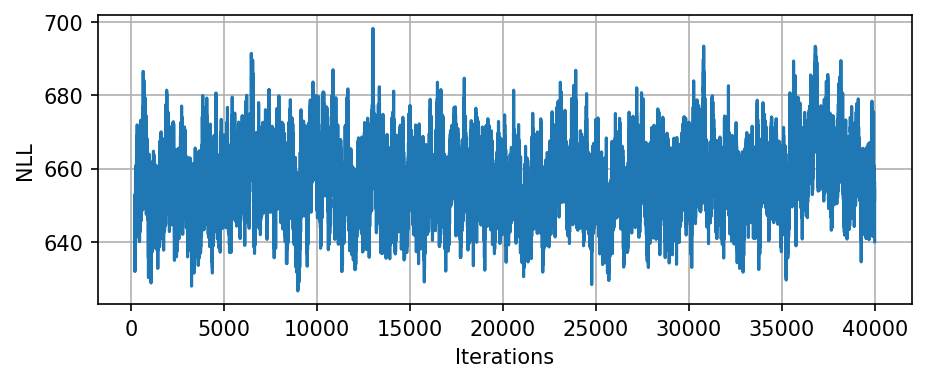

In [38]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

## Get target U

In [97]:
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[300:] #300 burn-in

In [7]:
x = np.linspace(0, 1, ndim)
X = x.reshape(-1, 1)

In [ ]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, len(est_samples)).T

opflow_std = np.std(est_samples, axis=0).squeeze()
opflow_mean = np.mean(est_samples, axis=0).squeeze()

sample_idx = np.random.choice(len(est_samples), 5, replace=False)

sample_idx_ofm = np.random.choice(len(est_samples), 5, replace=False)
samples_opflow = est_samples[sample_idx_ofm].squeeze()
samples_ground_truth = y_samples[sample_idx].squeeze()


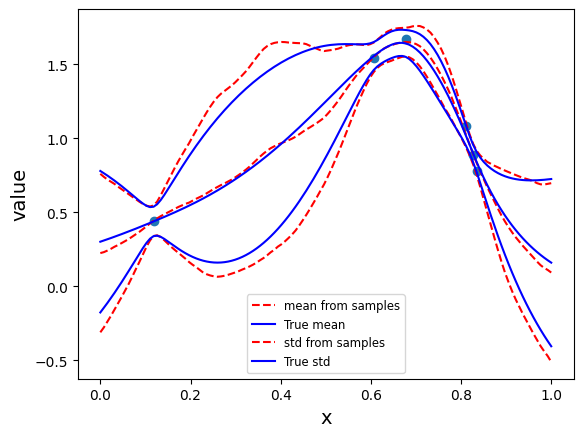

In [8]:
sample_std = np.std(est_samples, axis=0).squeeze()
sample_mean = np.mean(est_samples, axis=0).squeeze()

plt.plot(x, sample_mean, c='r', ls='--', label='mean from samples')
plt.plot(x, y_mean, c='b', label='True mean')
plt.plot(x, sample_mean-sample_std, c='r', ls='--', label='std from samples')
plt.plot(x, sample_mean+sample_std, c='r', ls='--')
plt.plot(x, y_mean-y_std,c='b', label='True std' )
plt.plot(x,y_mean+y_std, c='b')
plt.legend(fontsize='small')
plt.xlabel('x', fontsize=14)
plt.ylabel('value', fontsize=14)
plt.scatter(x_obs, u_obs_part)
#plt.savefig(f"paper_pdf/{folder}_SGLD_mean_std.pdf")

## Plot

In [35]:
saved_folder = 'GP2GP_OFM'
if not os.path.exists(f"../Regression_results/{saved_folder}"):
    os.makedirs(f"../Regression_results/{saved_folder}")

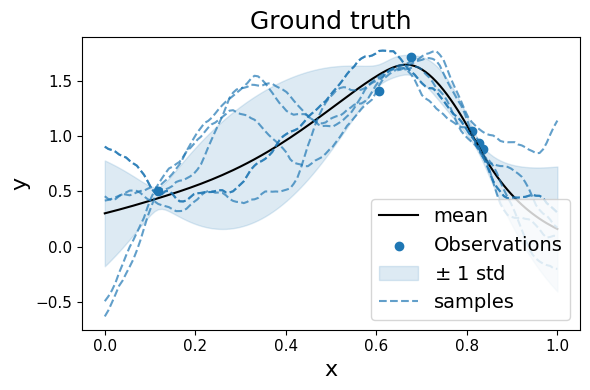

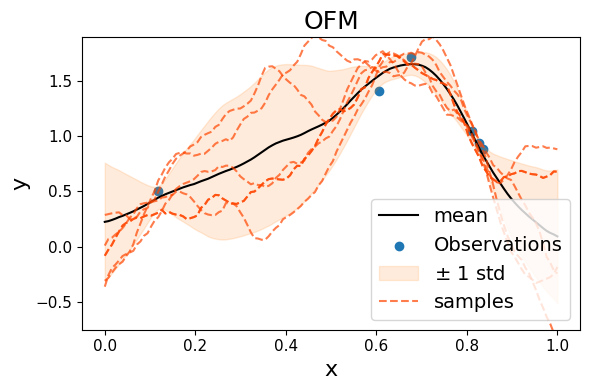

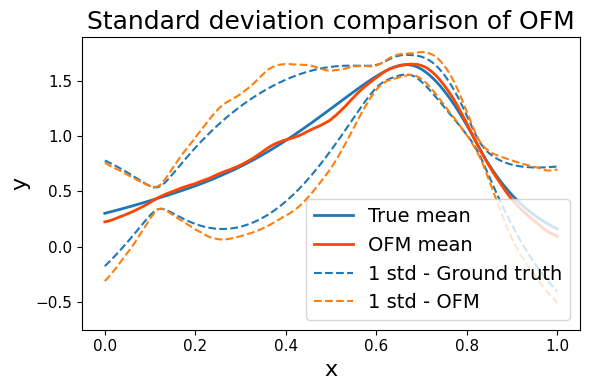

In [44]:
## Figure 1 (Ground Truth : mean + std + samples)
## Figure 2 (OpFlow : mean + std _samples)
## Figure 3 (Mean and Std comparision) 
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, y_mean, c='k', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.15, color="#1f77b4", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(samples_ground_truth):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#1f77b4')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#1f77b4', label=f"samples")

ax.set_title('Ground truth', fontsize=18)       
ax.legend(loc='lower right', fontsize=14)
y_lims = ax.get_ylim()
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y',fontsize=16)
plt.tick_params( labelsize=11)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GP_reg_gt.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, opflow_mean, c='black', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, opflow_mean - opflow_std, opflow_mean + opflow_std, alpha=0.15, color="#ff7f0e", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(samples_opflow):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#FF4500')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#FF4500', label=f"samples")
ax.set_title('OFM', fontsize=18)
#ax.set_title('OpFlow - Regression on A, white noise', fontsize=14)
ax.legend(loc='lower right', fontsize=14)
ax.set_ylim(y_lims)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y',fontsize=16)
plt.tick_params( labelsize=11)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GP_reg_ofm.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title('Standard deviation comparison of OFM', fontsize=18)
ax.plot(x_range, y_mean, lw=2, c='#1f77b4', label='True mean')
ax.plot(x_range, opflow_mean, lw=2, c='#FF4500', label='OFM mean')
#ax.plot(x_range, u_opflow_copy.squeeze(), lw=2, c='k', label='OpFlow MAP' )
ax.plot(x, y_mean-y_std,ls='--',c='#1f77b4', label=r'1 std - Ground truth' )
ax.plot(x,y_mean+y_std,ls='--', c='#1f77b4')
#ax.plot(x, y_mean-opflow_std, c='#ff7f0e', ls='--', label=r'1 $\sigma$ - OpFlow')
#ax.plot(x, y_mean+opflow_std, c='#ff7f0e', ls='--')
ax.plot(x, opflow_mean-opflow_std, c='#ff7f0e', ls='--', label=r'1 std - OFM')
ax.plot(x, opflow_mean+opflow_std, c='#ff7f0e', ls='--')
ax.legend(loc='lower right', fontsize=14)
ax.set_ylim(y_lims)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y',fontsize=16)
plt.tick_params( labelsize=11)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GP_reg_uncertainty.pdf")

In [130]:
# saved result as HDF5 

import h5py
f = h5py.File(f"../Regression_results/{saved_folder}/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=pos_idx)
f.create_dataset('noise_patter', data=noise_pattern.detach().cpu().numpy().squeeze())
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()